Let's explore the data, taking advantage of the features of the `fastai.medical.imaging` library, available in the prerelease of [fastai v2](https://dev.fast.ai). If you're interested in learning more about fastai v2, check out the [dedicated forum](https://forums.fast.ai/c/fastai-users/fastai-v2). For a deep dive, have a look at the 10 [fastai v2 code walkthru videos](https://forums.fast.ai/t/fastai-v2-daily-code-walk-thrus/53839). The overall approach in the library is described in detail (and many parts implememted from scratch) in the course [Deep Learning from the Foundations](https://course.fast.ai/part2.html).

Since this is a prerelease, it's not installed on Kaggle yet, so we'll install it and import the necessary modules.

In [1]:
!pip install torch torchvision feather-format kornia pyarrow --upgrade   > /dev/null
!pip install git+https://github.com/fastai/fastai_dev             > /dev/null

from fastai2.basics           import *
from fastai2.medical.imaging  import *

np.set_printoptions(linewidth=120)

ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
  Running command git clone -q https://github.com/fastai/fastai_dev /tmp/pip-req-build-tki5p4kd


In [2]:
path_inp = Path('../input')
path = path_inp/'rsna-intracranial-hemorrhage-detection'
path_trn = path/'stage_1_train_images'
path_tst = path/'stage_1_test_images'

# Reading the data

It's much faster and easier to analyze DICOM metadata when it's in a DataFrame. Converting a bunch of DICOM files into a metadata DataFrame is as simple as calling `pd.DataFrame.from_dicoms`. However it takes quite a while (particularly on Kaggle, due to the lack of RAM), so we'll import the DataFrame we've already created and saved in the [Creating a metadata DataFrame](https://www.kaggle.com/jhoward/creating-a-metadata-dataframe/) kernel. See that kernel for more details on how this is made.

In [3]:
path_df = path_inp/'creating-a-metadata-dataframe'

df_lbls = pd.read_feather(path_df/'labels.fth')
df_tst = pd.read_feather(path_df/'df_tst.fth')
df_trn = pd.read_feather(path_df/'df_trn.fth')

Let's merge the labels and DICOM data together into a single DataFrame. It's always good practice after a merge to assert that you haven't had any failed matches in your join.

In [4]:
comb = df_trn.join(df_lbls.set_index('ID'), 'SOPInstanceUID')
assert not len(comb[comb['any'].isna()])

This next output is worth studying - it's all the information we have (other than the actual pixels, of course!) about each of our images. As well as the DICOM metadata elements (which you can learn about with a Google search, since DICOM is a widely used standard), you'll see we also have `img_min`, `img_max`, `img_mean`, and `img_std` (which are the basic statistics of that images pixels), along with the labels for that image.

In [5]:
comb.head().T

,0,1,2,3,4
SOPInstanceUID,ID_71fa15682,ID_36e082057,ID_36f7f598f,ID_b34f8061e,ID_bbe87874d
Modality,CT,CT,CT,CT,CT
PatientID,ID_0ce53feb,ID_aa6a68bd,ID_c8c30baf,ID_3c4bab8c,ID_6587401a
StudyInstanceUID,ID_901c2a645f,ID_e0facea27b,ID_75960f44c5,ID_7a50278155,ID_8343c31c69
SeriesInstanceUID,ID_f14ee13c33,ID_540118cb45,ID_e799c303a0,ID_55c03039bf,ID_86ea1d2868
StudyID,,,,,
ImagePositionPatient,-125,-108,-104,-126.409,-125
ImageOrientationPatient,1,1,1,1,1
SamplesPerPixel,1,1,1,1,1
PhotometricInterpretation,MONOCHROME2,MONOCHROME2,MONOCHROME2,MONOCHROME2,MONOCHROME2


# Looking at metadata - BitsStored and PixelRepresentation

Two interesting fields are `BitsStored` and `PixelRepresentation`. These tell you whether the data is 12 bit or 16 bit, and whether it's stored as signed on unsiged data. Let's look at some image, metadata, and label statistics grouping on these fields. We'll use Pandas' powerful `pivot_table` function (which isn't as powerful as MS Excel's eponymous tool, but is pretty great nonetheless!)

In [6]:
repr_flds = ['BitsStored','PixelRepresentation']
comb.pivot_table(values=['img_mean','img_max','img_min','PatientID','any'], index=repr_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min','PatientID':'count','any':'mean'})

PatientID       any  img_max    img_mean  \
BitsStored PixelRepresentation                                             
12         0                       330327  0.126641     4095  450.991049   
           1                         2252  0.337034     2047 -639.221155   
16         1                       341679  0.159539    32767   55.947723   

                                img_min  
BitsStored PixelRepresentation           
12         0                          0  
           1                      -2048  
16         1                     -32768

The different frequencies of labels shown in the `any` column is interesting, suggesting that these groups may be from different institutions. Assuming that the stage 2 data will be from the same distribution (which the competition organizers have said is the case) then it should be safe to take advantage of this information. In general, using institution and machine metadata in this way can actually be helpful in practice in production models (as long as it's fine-tuned appropriately when used at new institutions).

As expected, the unsigned DICOMs have a minimum pixel value of zero. The range of the 16 bit data is of some concern, however, since in theory hounsfield units (which CT scans use) are not meant to be so extreme.

In theory, there are some DICOM elements that tell us how to scale and look at our data. Perhaps these will fix up the different representations for us. Let's look at a summary of them.

In [7]:
comb.pivot_table(values=['WindowCenter','WindowWidth', 'RescaleIntercept', 'RescaleSlope'], index=repr_flds,
                   aggfunc={'mean','max','min','std','median'})

RescaleIntercept                               \
                                            max         mean  median     min   
BitsStored PixelRepresentation                                                 
12         0                                1.0 -1023.135178 -1024.0 -1024.0   
           1                                0.0     0.000000     0.0     0.0   
16         1                                0.0 -1015.155956 -1024.0 -1024.0   

                                          RescaleSlope                        \
                                      std          max mean median  min  std   
BitsStored PixelRepresentation                                                 
12         0                    20.040220          1.0  1.0    1.0  1.0  0.0   
           1                     0.000000          1.0  1.0    1.0  1.0  0.0   
16         1                    94.752889          1.0  1.0    1.0  1.0  0.0   

                               WindowCenter                          \
                                        max       mean median   min   
BitsStored PixelRepresentation                                        
12         0                          650.0  37.946925   36.0  25.0   
           1                          350.0  49.009769   40.0  40.0   
16         1                          800.0  34.076297   30.0  25.0   

                                          WindowWidth                     \
                                      std         max        mean median   
BitsStored PixelRepresentation                                             
12         0                    19.219504      4095.0   85.180503   80.0   
           1                    48.157162      4000.0  182.309059   80.0   
16         1                    21.021467      3000.0  104.533656   80.0   

                                                  
                                 min         std  
BitsStored PixelRepresentation                    
12         0                    26.0  128.366392  
           1                    80.0  611.029963  
16         1                    60.0  105.059073

Well... that doesn't look good! Although when `PixelRepresentation` is zero, there's *normally* a `RescaleIntercept` of `-1024` to give us signed data (as we would expect, since hounsfield units can be negative), the max `RescaleIntercept` for that row is `1.0`. Curiously, `RescaleIntercept` is normally also `-1024` when `PixelRepresentation` is one, even although it's signed data, which means that shouldn't be necessary.

Also, `RescaleSlope` is always `1.0`, so it's not going to fix the very extreme pixel values in the 16 bit data. Let's see how often that happens. To make our analyses easier, we'll create DataFrames for each subset we're interested in.

In [8]:
df1 = comb.query('(BitsStored==12) & (PixelRepresentation==0)')
df2 = comb.query('(BitsStored==12) & (PixelRepresentation==1)')
df3 = comb.query('BitsStored==16')
dfs = [df1,df2,df3]

Now we can see how often images occur with extreme values. We'll use a little function that summarizes the distribution of values.

In [9]:
def distrib_summ(t):
    plt.hist(t,40)
    return array([t.min(),*np.percentile(t,[0.1,1,5,50,95,99,99.9]),t.max()], dtype=np.int)

array([ -376,   878,  1324,  1776,  2779,  4095,  5947, 28517, 32767])

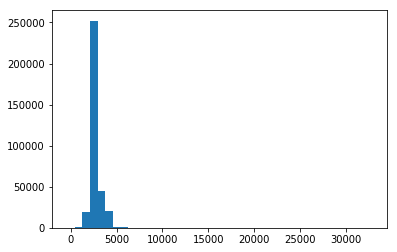

In [10]:
distrib_summ(df3.img_max.values)

array([-32768,  -3024,  -2000,  -2000,  -2000,      0,      0,      1,     23])

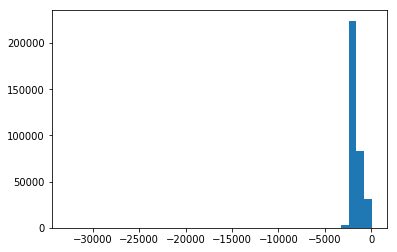

In [11]:
distrib_summ(df3.img_min.values)

We can see that extreme values occur in only a very small number of images. We may want to clip these images in the dataset. We'll need to be careful, because these extreme values appear in the test set too:

array([   25,   792,  1321,  1907,  2773,  4095,  4095,  7554, 32765])

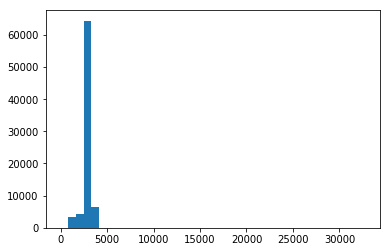

In [12]:
distrib_summ(df_tst.img_max.values)

# Looking at image data

We'll open a few images so we can look at their pixel data.

In [13]:
dcms = path_trn.ls(10).map(dcmread)
dcm = dcms[0]
dcm

(0008, 0018) SOP Instance UID                    UI: ID_231d901c1
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_b81a287f'
(0020, 000d) Study Instance UID                  UI: ID_dd37ba3adb
(0020, 000e) Series Instance UID                 UI: ID_15dcd6057a
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000', '-123.101', '104.307']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.984808', '-0.173648']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored         

Let's see what format the pixel data is in.

In [14]:
dcms_px = dcms.attrgot('pixel_array')

In [15]:
list(zip(dcms_px.attrgot('dtype'),
         dcms.attrgot('PixelRepresentation'),
         dcms.attrgot('BitsStored')))

[(dtype('int16'), 1, 16),
 (dtype('uint16'), 0, 12),
 (dtype('int16'), 1, 16),
 (dtype('uint16'), 0, 12),
 (dtype('uint16'), 0, 12),
 (dtype('uint16'), 0, 12),
 (dtype('uint16'), 0, 12),
 (dtype('int16'), 1, 16),
 (dtype('int16'), 1, 12),
 (dtype('int16'), 1, 16)]

We see here that we are automatically given unsigned or signed int16 arrays, based on the `PixelRepresentation` element.

**Be Careful!** This means that if you use `RescaleIntercept` to rescale the uint16 arrays, you'll end up wrapping around to large positive numbers, instead of creating negative numbers!

Instead of doing this manually, use fastai's `scaled_px` attribute, which turns everything into a float and applies rescaling automatically. This is a good example of the kind of nasty "gotchas" that can occur when working with medical images. It's best, where possible, to automatically handle these inside libraries, since otherwise the bugs that can creep in can be hard to spot.

In [16]:
dcm.scaled_px.type()

'torch.FloatTensor'

Another benefit of using `scaled_px` is that it returns a PyTorch tensor, which allows you to do image transformations in full floating point precision, accelerated on the GPU. fastai v2 has a wide range of GPU-accelerated transformations, which we will look at in a future notebook.

fastai will attempt to automatically normalize the image for basic viewing, without having to worry about windowing.

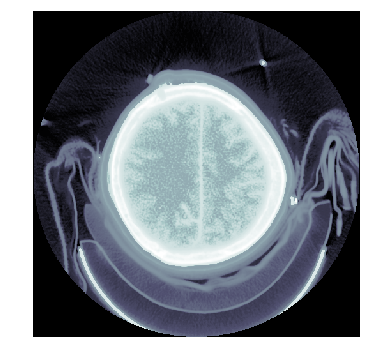

In [17]:
dcm.show(figsize=(6,6))

A range of windows are also provided, based on recommendations from [Radiopaedia](https://radiopaedia.org/articles/windowing-ct) (or you can set up your own), or you can also look at the raw data.

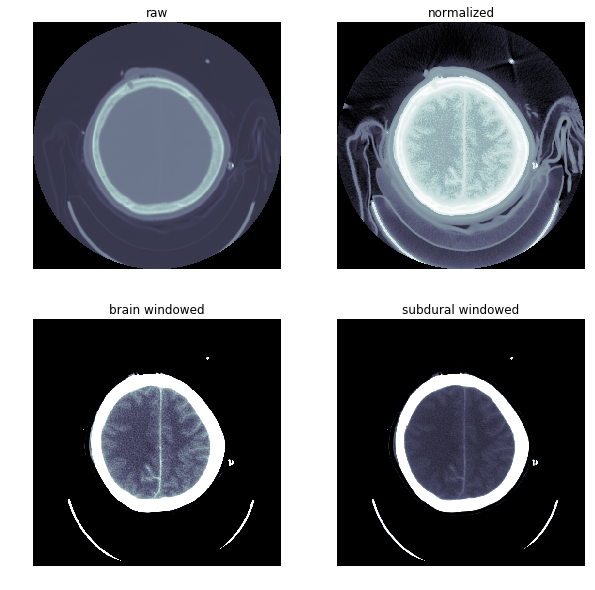

In [18]:
scales = False, True, dicom_windows.brain, dicom_windows.subdural
titles = 'raw','normalized','brain windowed','subdural windowed'
for s,a,t in zip(scales, subplots(2,2,imsize=5)[1].flat, titles):
    dcm.show(scale=s, ax=a, title=t)

I've analyzed the issue of windowing and leveraging floating point data in much more detail in this notebook: [DON'T see like a radiologist](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai). It builds on top of the work done in this current notebook.

I'll announce new kernels on my [Twitter account](https://twitter.com/jeremyphoward), and don't forget to drop by the  [fastai v2 forum](https://forums.fast.ai/c/fastai-users/fastai-v2) for more resources, Q&A, and discussions.